    In this notebook we'll implement GoogLeNet with Inception blocks from scratch
    using Pytorch
    
    We'll use a tiny version of ImageNet to experiment with
    
    The code is followed by some explanation
    
    Original article: https://arxiv.org/pdf/1409.4842.pdf

In [55]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader


torch.manual_seed(17)

In [56]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Feb 28 2025

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

pandas     : 2.2.2
torchvision: 0.18.0
torch      : 2.3.0
PIL        : 10.3.0
matplotlib : 3.9.0
numpy      : 1.26.4

Watermark: 2.4.3



# Data preparation

Define the transformations we will apply to images:
1. Resize the images so they match the size of images the architecture was developed for
2. Convert PIL Images to tensors to process inside the network


In [57]:
data_dir = './data/tiny-imagenet-200'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [58]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        if self.train:
            self.data = []
            self.labels = []
            classes = os.listdir(os.path.join(root_dir, 'train'))
            for label, cls in enumerate(classes):
                cls_dir = os.path.join(root_dir, 'train', cls, 'images')
                for img_name in os.listdir(cls_dir):
                    self.data.append(os.path.join(cls_dir, img_name))
                    self.labels.append(label)
        else:
            self.data = []
            self.labels = []
            val_dir = os.path.join(root_dir, 'val', 'images')
            val_annotations = pd.read_csv(os.path.join(root_dir, 'val', 'val_annotations.txt'), 
                                          sep='\t', header=None, 
                                          names=['file_name', 'class', 'x1', 'y1', 'x2', 'y2'])
            class_to_idx = {cls: idx for idx, cls in enumerate(sorted(os.listdir(os.path.join(root_dir, 'train'))))}
            for _, row in val_annotations.iterrows():
                self.data.append(os.path.join(val_dir, row['file_name']))
                self.labels.append(class_to_idx[row['class']])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Defining the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [59]:
train_data = TinyImageNetDataset(root_dir=data_dir, transform=transform, train=True)
val_data = TinyImageNetDataset(root_dir=data_dir, transform=transform, train=False)
len(train_data), len(val_data)

(100000, 10000)

In [60]:
transform = transforms.Compose([ 
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

Create the dataset and the DataLoaders to benefit from batching and shuffling

In [61]:
#train_data = torchvision.datasets.ImageFolder('./data/tiny-imagenet-200/train', transform=transform)
#val_data = torchvision.datasets.ImageFolder('./data/tiny-imagenet-200/val', transform=transform)
#test_data = torchvision.datasets.ImageFolder('./data/tiny-imagenet-200/test', transform=transform)
# len(train_data), len(val_data), len(test_data)

In [62]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)

Visualise training images

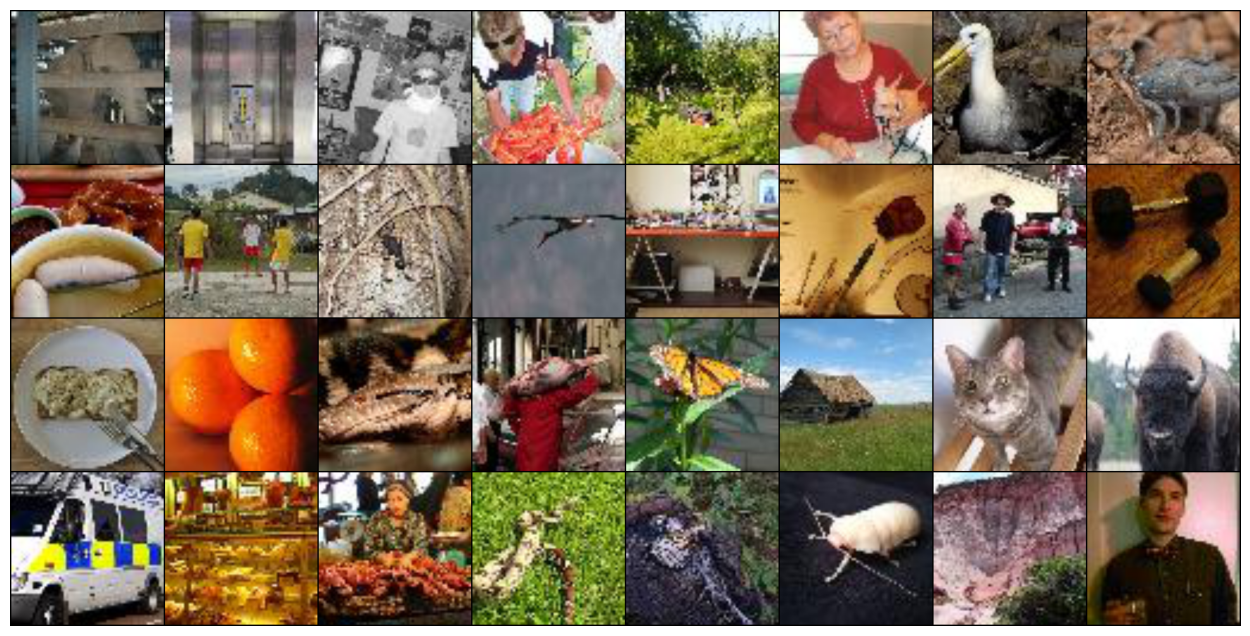

In [63]:
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

# Model

#### Building blocks for GoogLeNet model:
1. Conv2d + BatchNorm2d + ReLU block class
2. Inception block class
3. Auxiliary classifier class
4. Model class

With this implementation we can either use auxiliary classifiers during training (see the original article) or turn it off using *use_auxiliary* parameter.

In [64]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

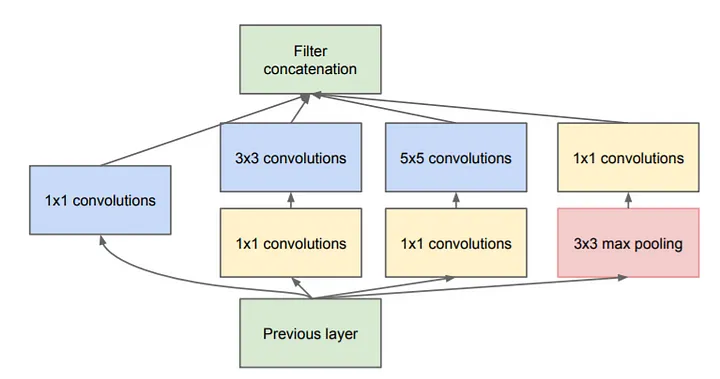

In [65]:
class InceptionBlock(nn.Module):
    
    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()
        
        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)
        
        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)  
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)
        
        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)
         
    def forward(self, x):
        x1 = self.one_by_one(x)
        
        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)
        
        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)
        
        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)
        
        x = torch.cat([x1, x2, x3, x4], 1)
        return x

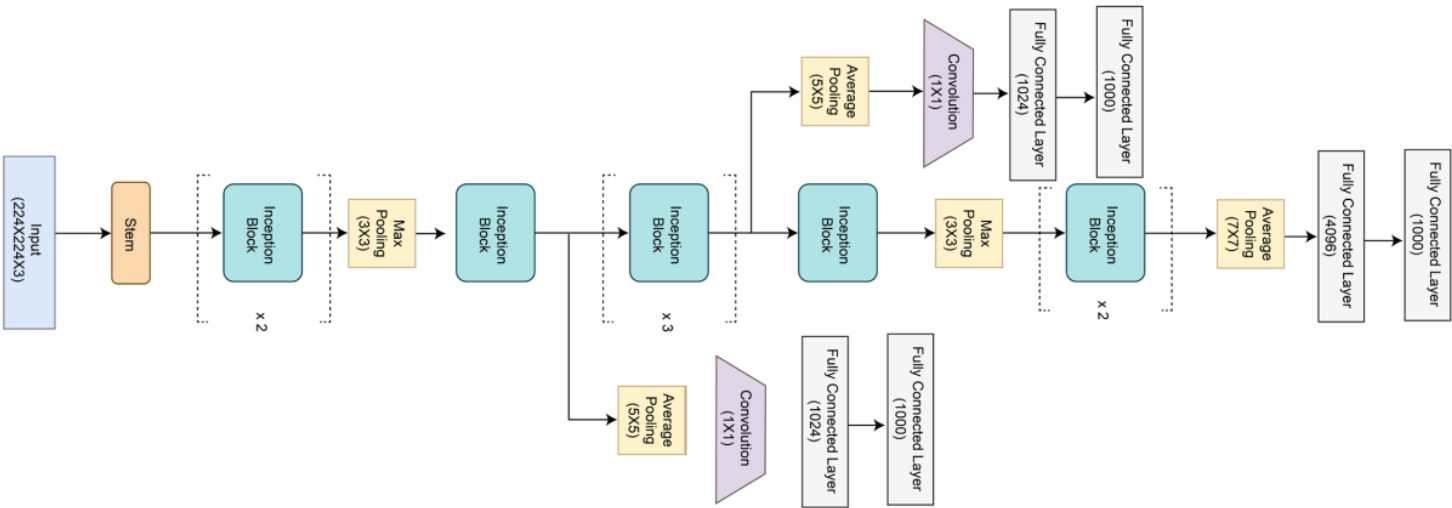

In [66]:
class Auxiliary(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [67]:
class Inception(nn.Module):
    
    def __init__(self, in_channels=3, use_auxiliary=True, num_classes=1000):
        super(Inception, self).__init__()
        
        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, num_classes)
        
        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)
        
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None
        
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        
        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)
        
        x = self.inception4e(x)
        x = self.maxpool(x)
        
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        
        x = self.linear(x)
        
        return x, y, z

The only noticable difference from the traditional convolutional layer here is that the input is divided to branches, each of which has own operations. After all the operations have been performed we concatenate the branches into one output tensor

An auxiliary classifier is a classification block that stems from one of the intermediate layers. We take its predictions into account to help the network to propagate gradients through the more recent layers.

In [68]:
model = Inception()

In [69]:
#define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [70]:
#move the model to the device
model.to(device)
next(model.parameters()).is_cuda
print(model)

Inception(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=1024, out_features=1000, bias=True)
  (auxiliary4a): Auxiliary(
    (avgpool): AvgPool2d(kernel_size=5, stride=3, padding=0)
    (conv1x1): ConvBlock(
      (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    

# Training

In [71]:
#define everything we need for training
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Take a look at the training function. If *use_auxiliary=True*, during training we take into account predictions made by auxiliary classifiers - we add their weighted losses to the loss of the main classifier

In [72]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_auxiliary=True):
    
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    if phase == 'train': # Backward + optimize only if in training phase
                        if use_auxiliary:
                            outputs, aux1, aux2 = model(inputs)
                            loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                        else:
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels)
                            
                        _, preds = torch.max(outputs, 1)
                        loss.backward()
                        optimizer.step()
                    
                    if phase == 'val':
                        outputs, _, _ = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
model, _ = train_model(model, {"train": train_loader, "val": val_loader}, criterion, optimizer, epochs)

Epoch 0/49
----------


In [ ]:
import torchvision.models as models
model = models.googlenet(pretrained=True)
model